# Projections under RCP 8.5 and RCP 2.6 scenarios in ISMIP6 models of Antarctica

##### Description:
This recipe recreates the analysis of Section 4.5 of Hélène Seroussi et al. 2020 (https://doi.org/10.5194/tc-14-3033-2020). 

Two CMIP5 models were chosen to run both RCP 8.5 and RCP 2.6 experiments: NorESM1-M and IPSL-CM5A-MR. Figure 9 shows the evolution of the Antarctic ice sheet under these two scenarios relative to ctrl_proj for both models. 

##### Written by: 
Paula Boubel, Oct 2024

##### Data requirements: 
The ISMIP6 model projections (see https://theghub.org/groups/ismip6/wiki/ISMIP6-Projections-Antarctica) available now on Gadi in /g/data/kj13/datasets/ismip6/ISMIP6-Projection-AIS

##### Python requirements: 
- Python 3
- xarray
- matplotlib
- numpy
- pandas

In [1]:
# lets import xarray and numpy
%matplotlib inline
%config InlineBackend.figure_format='retina'
import IPython.display

import matplotlib.pyplot as plt
import xarray as xr
import numpy as np

In [43]:
## Load utils.py from wherever it's located
%run -i "/g/data/tm70/pb9726/access-issm-cookbook/ISMIP6/utils.py"

In [28]:
datapath = "/g/data/kj13/datasets/ismip6/ISMIP6-Projection-AIS" # Supply the path to the location of the ISMIP6 model data

ismip6 = AllModels(datapath) # Initialise the AllModels class, which will allow us to find, load, and combine datasets

#For this recipe we only need to load the following variables:
variables = ['lithk','sftflf','sftgrf'] # Names of variables to retrieve
org_list = ['AWI','IMAU','ILTS_PIK','LSCE','NCAR','UCIJPL','JPL1','ULB','VUB'] # Institutions we want to look at 

In [29]:
## Get the data
ism_dataset = ismip6.get_combined_models(org_list, ['ctrl_proj_std','exp05','exp07'], variables)

AWI PISM1
IMAU IMAUICE1
IMAU IMAUICE2
ILTS_PIK SICOPOLIS1
LSCE GRISLI2
NCAR CISM
UCIJPL ISSM
JPL1 ISSM
ULB fETISh_32km
ULB fETISh_16km
VUB AISMPALEO


In [47]:
## We now have a dataset combining models and experiments in a standard format
ism_dataset

<xarray.Dataset> Size: 41GB
Dimensions:     (model: 11, experiment: 3, time: 86, y: 761, x: 761, bnds: 2,
                 nv4: 4)
Coordinates:
  * x           (x) float64 6kB -3.04e+03 -3.032e+03 ... 3.032e+03 3.04e+03
  * y           (y) float64 6kB -3.04e+03 -3.032e+03 ... 3.032e+03 3.04e+03
  * time        (time) int64 688B 0 1 2 3 4 5 6 7 8 ... 78 79 80 81 82 83 84 85
    lat         (y, x) float32 2MB -51.85 -51.9 -51.94 ... -51.94 -51.9 -51.85
    lon         (y, x) float32 2MB -135.0 -135.1 -135.2 ... 44.85 44.92 45.0
  * experiment  (experiment) object 24B 'ctrl_proj_std' 'exp05' 'exp07'
  * model       (model) object 88B 'AWI/PISM1' ... 'VUB/AISMPALEO'
Dimensions without coordinates: bnds, nv4
Data variables:
    lithk       (model, experiment, time, y, x) float64 13GB dask.array<chunksize=(1, 1, 1, 86, 381), meta=np.ndarray>
    time_bnds   (model, experiment, time, bnds) float64 45kB dask.array<chunksize=(1, 1, 1, 2), meta=np.ndarray>
    sftflf      (model, experiment, time, y, x) float64 13GB dask.array<chunksize=(1, 1, 1, 86, 381), meta=np.ndarray>
    sftgrf      (model, experiment, time, y, x) float64 13GB dask.array<chunksize=(1, 1, 1, 86, 381), meta=np.ndarray>
    lon_bnds    (model, experiment, y, x, nv4) float64 612MB dask.array<chunksize=(2, 1, 381, 381, 1), meta=np.ndarray>
    lat_bnds    (model, experiment, y, x, nv4) float64 612MB dask.array<chunksize=(2, 1, 381, 381, 1), meta=np.ndarray>
    crs         (model, experiment) float32 132B nan nan nan nan ... nan nan nan
    year        (model, experiment, time) float32 11kB dask.array<chunksize=(11, 3, 86), meta=np.ndarray>
    mmsle       (time, experiment, model) float64 23kB -0.0 -0.0 ... 0.9474
Attributes:
    Conventions:  CF-1.6
    title:        ISMIP6 Projections Greenland model output
    institution:  Alfred Wegener Institute for Polar and Marine Research, DE,...
    source:       PISM
    references:   https://doi.org/10.5194/tc-14-3033-2020
    contact:      Name = Thomas Kleiner, Johannes Sutter, Angelika Humbert, E...
    comment:      AWI, PISM1

## Calculating the sea level rise

We first need to find how much grounded ice mass is being lost by integrating the ice thickness over the area of Antarctica each year:

This is done by summing up the product of the ice thickness $h$ with the grid area $\textrm{d}A$ over all grid points $i$, scaled by the fraction of that grid area for which that ice is grounded $F_{\text{grounded}}$: $V_{\text{grounded}} = \sum_i \left( h_{\text{i}} \times \textrm{d}A_i \times F_{\text{grounded},i} \right)$ 

Then, in order to find the volume of water that would be displaced by this ice, we need to scale by the ratios of density:
$V_{\text{water}} = V_{\text{grounded}} \times \frac{\rho_{\text{ice}}}{\rho_{\text{seawater}}}$

Finally, to get the rise in the sea level, $\Delta h$, we use the surface area of the ocean, $A_{\text{ocean}}$:
$\Delta h = \frac{V_{\text{water}}}{A_{\text{ocean}}} \times 10^6 \, \text{mm}$

In [37]:
num_model = len(ism_dataset.coords['model'])
num_exp = len(ism_dataset.coords['experiment'])
num_tt = len(ism_dataset.coords['time'])

## Create a new data arary in which we will store our new variable: the sea level rise in mm
mmSLE = xr.DataArray(
    np.zeros((num_tt, num_exp, num_model)),
    dims=['time', 'experiment', 'model'],
    coords={
        'time': ism_dataset.coords['time'],
        'experiment': ism_dataset.coords['experiment'],
        'model': ism_dataset.coords['model']
    },
    name='mmsle'  # Name of the new variable
)

print('Calculating sea level rise projection from '+model)

## Iterate through all models and experiments and compute the total ice mass and corresponding sea level rise, then store the result in mmSLE
## Note: in each case, we subtract the value obtained from the 'control' experiment
for i in range(num_model):
    model = str(ism_dataset.coords['model'][i].data)
    print(model)
    ism_model = ism_dataset.sel(model=model)
    ice_mass_ctrl = get_ice_mass_area(ism_model.sel(experiment='ctrl_proj_std').lithk,fraction=ism_model.sel(experiment='ctrl_proj_std').sftgrf.isel(time=0))[0]
    for j in range(num_exp):
        exp = str(ism_dataset.coords['experiment'][j].data)
        ice_mass_exp = get_ice_mass_area(ism_model.sel(experiment=exp).lithk,fraction=ism_model.sel(experiment=exp).sftgrf.isel(time=0))[0]
        ice_above_floatation = ice_mass_exp.values - ice_mass_ctrl.values
        sle = sea_level_rise(-ice_above_floatation*1e7)
        mmSLE.sel(experiment=exp, model=model)[:] = sle
        
ism_dataset['mmsle'] = mmSLE

AWI/PISM1
IMAU/IMAUICE1
IMAU/IMAUICE2
ILTS_PIK/SICOPOLIS1
LSCE/GRISLI2
NCAR/CISM
UCIJPL/ISSM
JPL1/ISSM
ULB/fETISh_32km
ULB/fETISh_16km
VUB/AISMPALEO


## Save the dataset as an nc file

In [45]:
## Save this dataset to use again later
# filename = '/g/data/tm70/pb9726/access-issm-cookbook/ISMIP6/fig9_dat.nc'
# print ('saving to ', filename)
# ism_dataset.to_netcdf(path=filename)
# ism_dataset.close()
# print ('finished saving')

## Figure 9

Impact of RCP scenario on projected evolution of ice volume above floatation for the NorESM1-M (a) and IPSL (b) models. Red and blue curves show mean evolution for RCP 8.5 and RCP 2.6, respectively, and the shaded background shows the standard deviation.



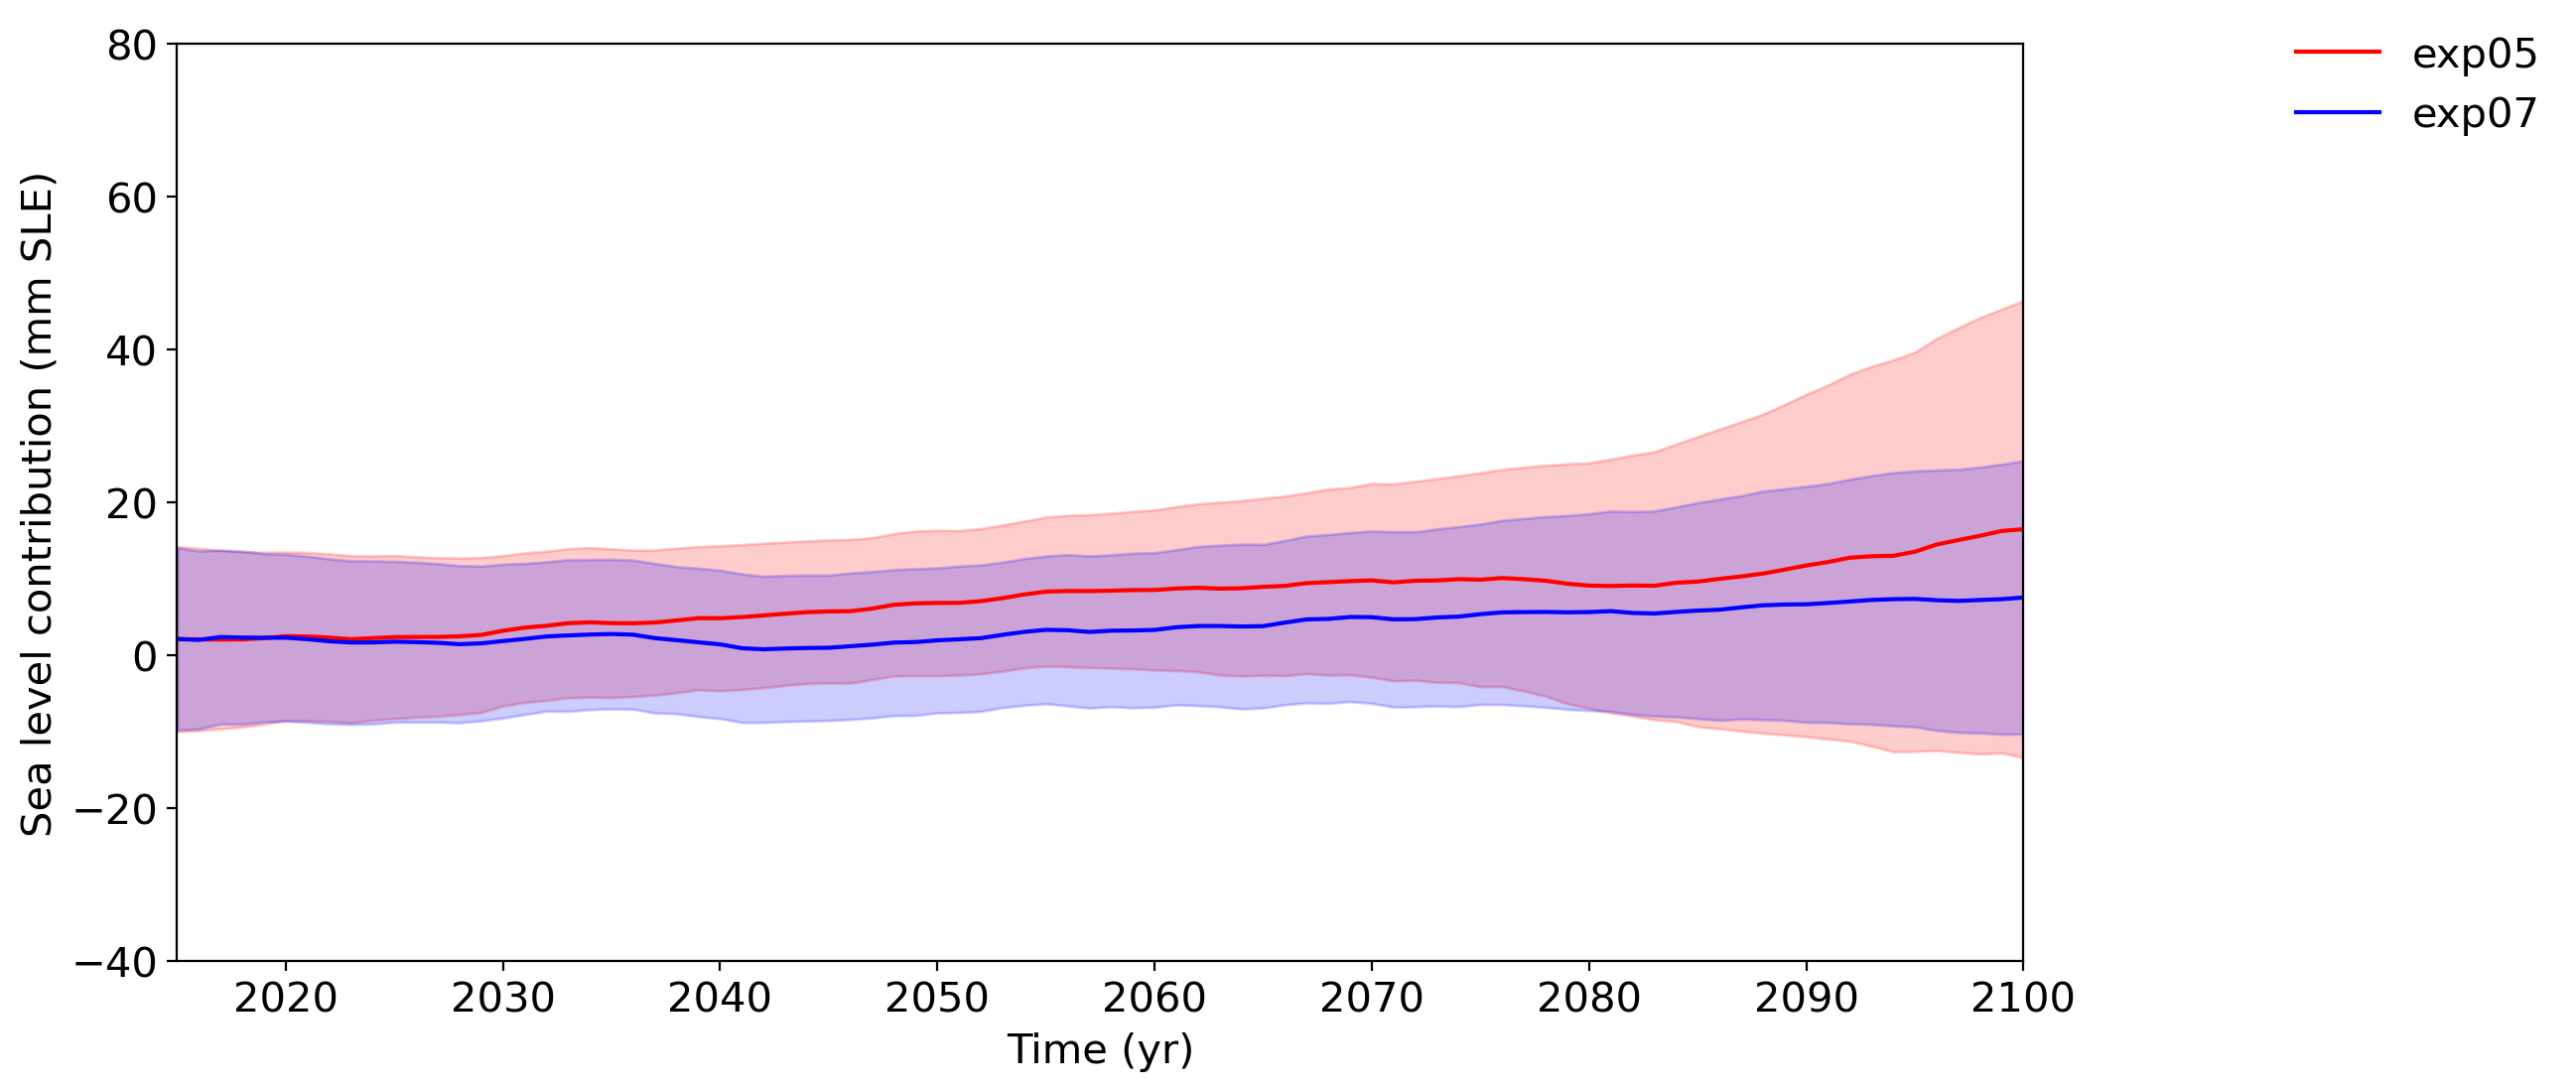

In [46]:
plt.figure(figsize=(12,6))
num_tt = len(ism_dataset.coords['time'])
colors = {'exp05':'red','exp07':'blue'}
years = 2015 + np.arange(num_tt)

for exp in ['exp05','exp07']:
    mean_SLE = ism_dataset.sel(experiment=exp).mmsle.mean(dim='model', skipna=True)
    std_SLE = ism_dataset.sel(experiment=exp).mmsle.std(dim='model', skipna=True)

    plt.plot(years, mean_SLE, color=colors[exp], label=exp)
    plt.fill_between(years, mean_SLE+std_SLE, mean_SLE-std_SLE, color=colors[exp], alpha=0.2)
    
plt.legend(fontsize=15, bbox_to_anchor=(1.3, 1.05), frameon=False)
plt.ylabel(r'Sea level contribution (mm SLE)', fontsize=15)
plt.xlabel('Time (yr)', fontsize=15)
plt.ylim(-40,80)
plt.xlim(2015, 2100)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig('figure9.png')